###### Inicialização

In [ ]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.tsatools import freq_to_period
from datetime import datetime, date
from IPython.display import Markdown

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

import seaborn as sns
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
def resultado_teste(stat, p):
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (stat, p)))
  # interpretando resultados
  alpha = 0.05
  if p > alpha:
      display(Markdown("**A amostra parece Gaussiana (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A amostra não parece Gaussiana (rejeitamos H0)**'))

# Análise de Séries temporais (Sessão 6)
---
Pré-processamento (parte 3)


## Filtragem





Estimar explicitamente tendências ($T_t$) e efeitos sazonais ($S_t$) para o cálculo da sequência de variáveis aleatórias:

\begin{align}
X_t= T_t + S_t + R_t \\
R_t= X_t - (T_t + S_t)
\end{align}

#### Construindo os dados sintétios

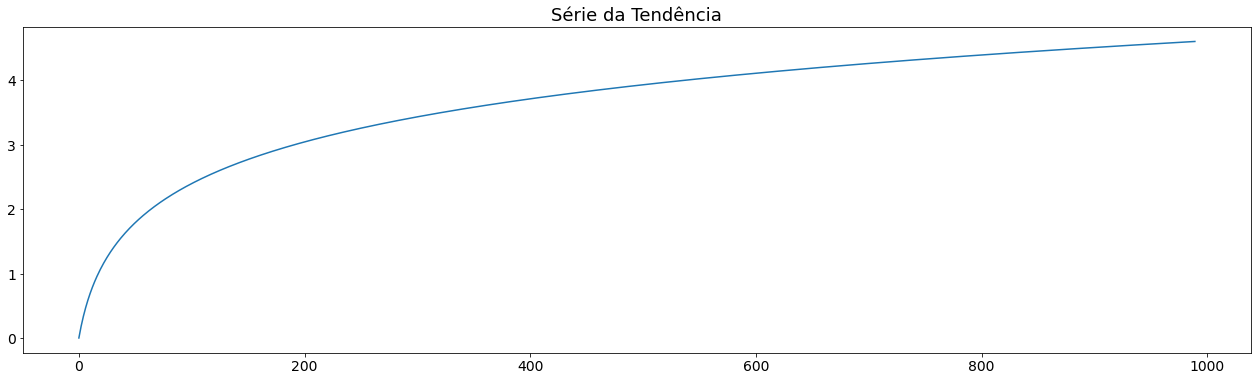

In [ ]:
x = np.arange(1, 100, 0.1)
T = pd.Series(np.log(x))
_ = T.plot(kind='line', title="Série da Tendência")

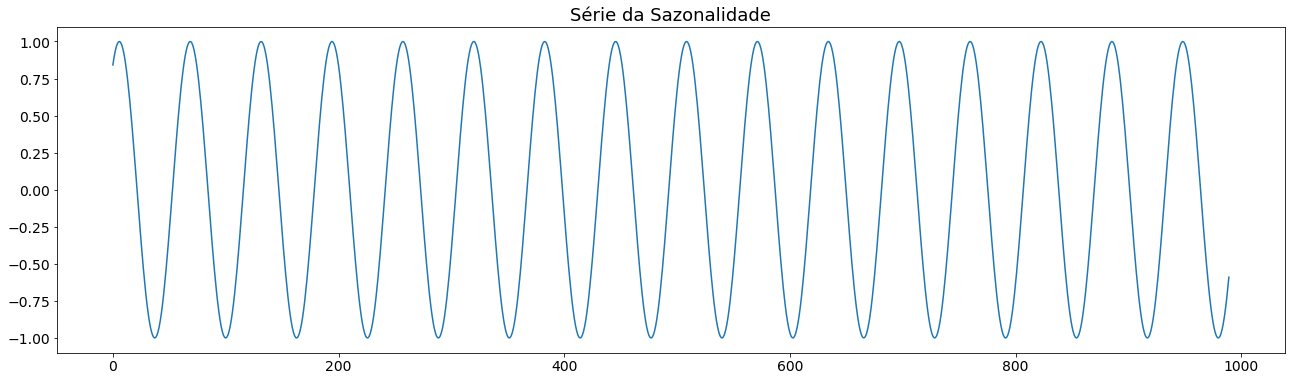

In [ ]:
S = pd.Series(np.sin(x))
_ = S.plot(kind='line', title="Série da Sazonalidade")

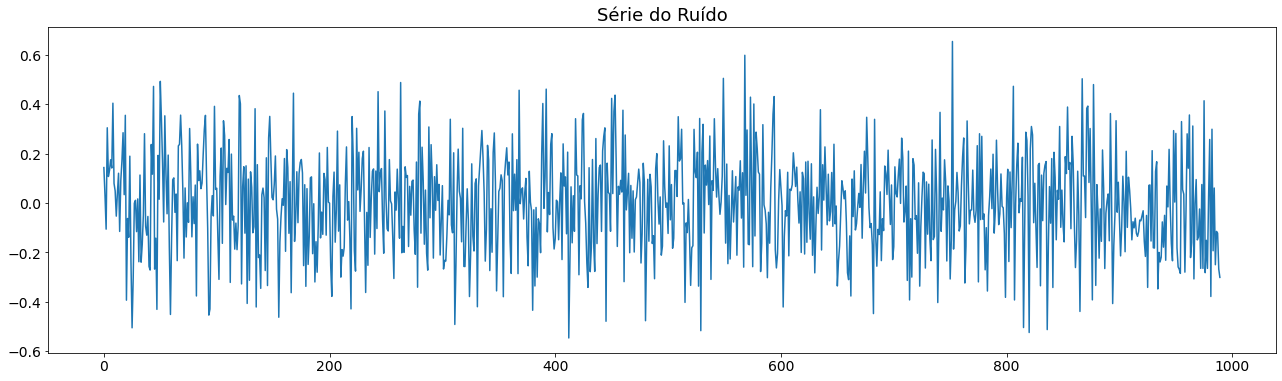

In [ ]:
mu = 0
sigma = .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)
_ = R.plot(kind='line', title="Série do Ruído")

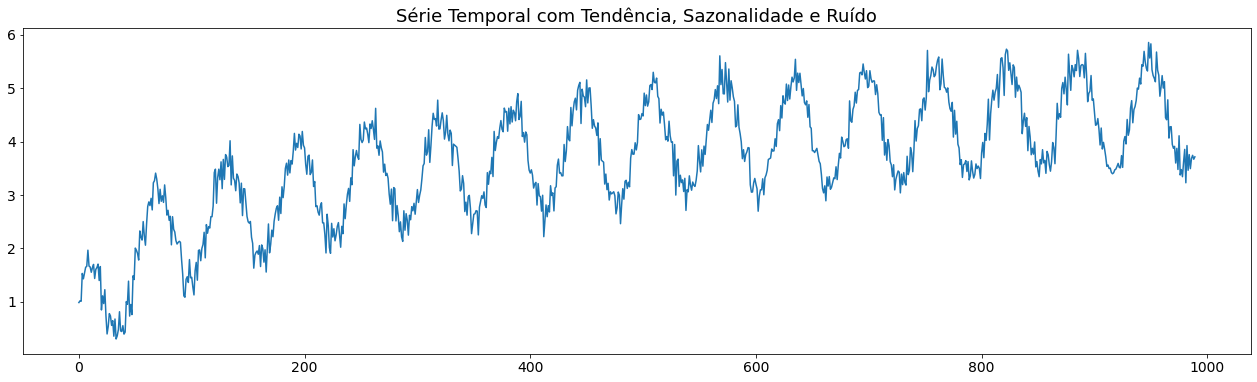

In [ ]:
X = T + S + R
_ = X.plot(kind='line', title="Série Temporal com Tendência, Sazonalidade e Ruído")

\begin{align}
R_t= X_t - (T_t + S_t)
\end{align}

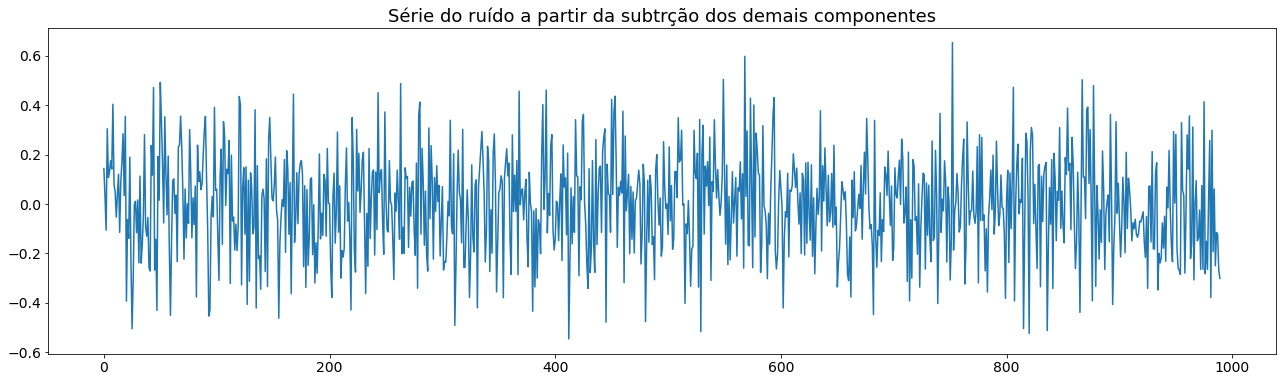

In [ ]:
R_ = X - (T + S)
_ = R_.plot(kind='line', title="Série do ruído a partir da subtrção dos demais componentes")

#### Obtendo os dados reais

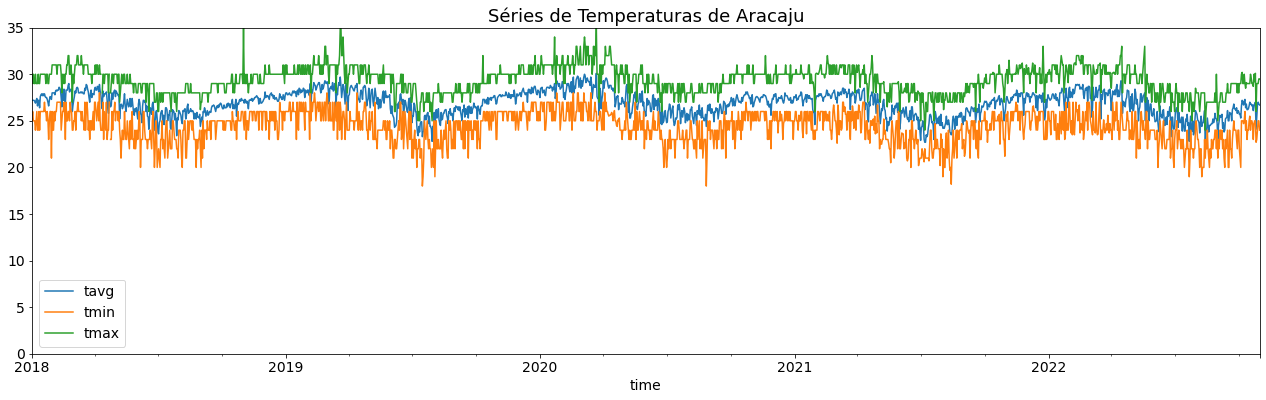

In [ ]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

_ = serie_aracaju.plot(y=['tavg', 'tmin', 'tmax'], title="Séries de Temperaturas de Aracaju", ylim=(0,35))

In [ ]:
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start="2007-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


### Filtragem da Tendência

Na ausência de efeitos sazonais, a tendência de uma série temporal pode ser estimada pela média móvel (filtro):

\begin{align}
T_i = \frac{1}{2n+1} \sum_{i = -n}^{n}{X_{t+1}}
\end{align}

##### Aplicando nos dados sintéticos

In [ ]:
n = 30
X_ = X.to_frame()
X_.columns = ["X"]

for i in range(n):
  X_[f"X_lag{i+1}"] = X_["X"].shift(-(i+1))
  X_[f"X_lead{i+1}"] = X_["X"].shift(i+1)

X_[f"mm{n}"] = X_.sum(axis=1) / (2*n + 1)
X_ = X_.iloc[n:]
X_ = X_.iloc[:-n]

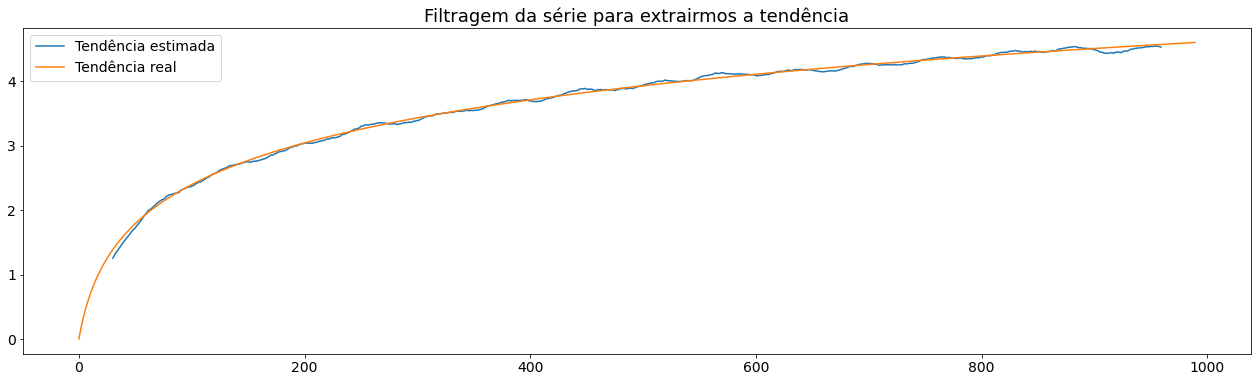

In [ ]:
ax = X_[f"mm{n}"].plot(title="Filtragem da série para extrairmos a tendência", label="Tendência estimada", legend= True)
_ = T.plot(ax=ax, label="Tendência real", legend= True)

No caso da série temporal apresentar tendência e efeito sazonal, a tendência pode ser estimada pela média móvel sazonal(filtro):

\begin{align}
T_t = \frac{1}{d}(\frac{1}{2} X_{t-q} + X_{t-q+1} + ... + X_{t+q-1} + \frac{1}{2} X_{t+q})
\end{align}

para $d = 2q, q < t < N - q$

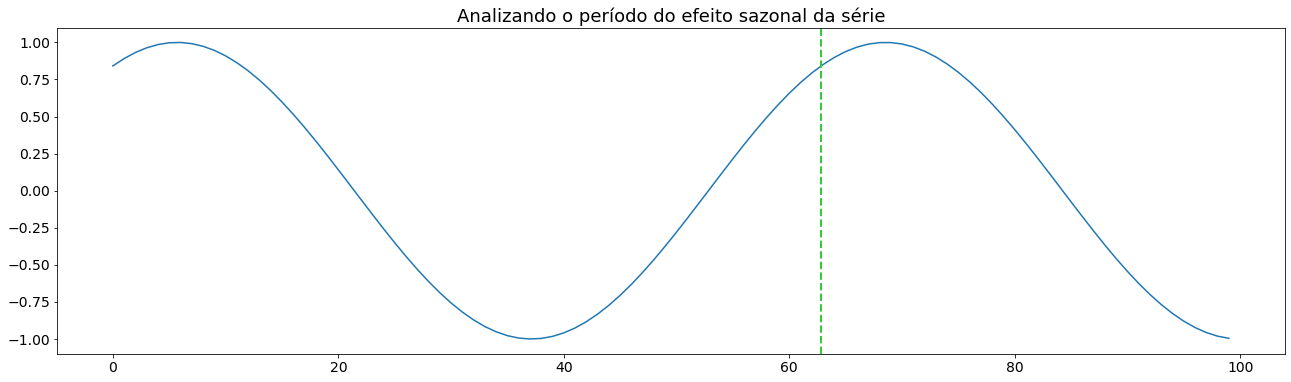

In [ ]:
ax = S[:100].plot(title = "Analizando o período do efeito sazonal da série")
_ = ax.axvline(2*np.pi*10, color='limegreen', ls='--', lw=2)

In [ ]:
d = int(2*np.pi*10 + 2)
q = d // 2
X__ = X.to_frame()
X__.columns = ["X"]

for i in range(q):
  X__[f"X_lag{i+1}"] = X__["X"].shift(-(i+1-q)) if i != (q-1) else X__["X"].shift(-(i+1-q))/2
  X__[f"X_lead{i+1}"] = X__["X"].shift((i+1-q)) if i != (q-1) else X__["X"].shift((i+1-q))/2

X__[f"mm{d}"] = X__.sum(axis=1) / (d)
X__ = X__.iloc[q:]
X__ = X__.iloc[:-q]

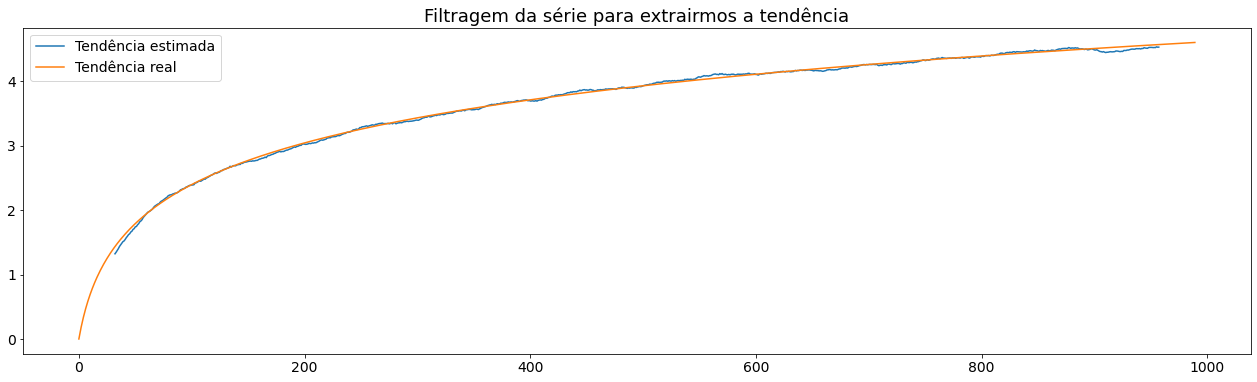

In [ ]:
ax = X__[f"mm{d}"].plot(title="Filtragem da série para extrairmos a tendência", label="Tendência estimada", legend= True)
_ = T.plot(ax=ax, label="Tendência real", legend= True)

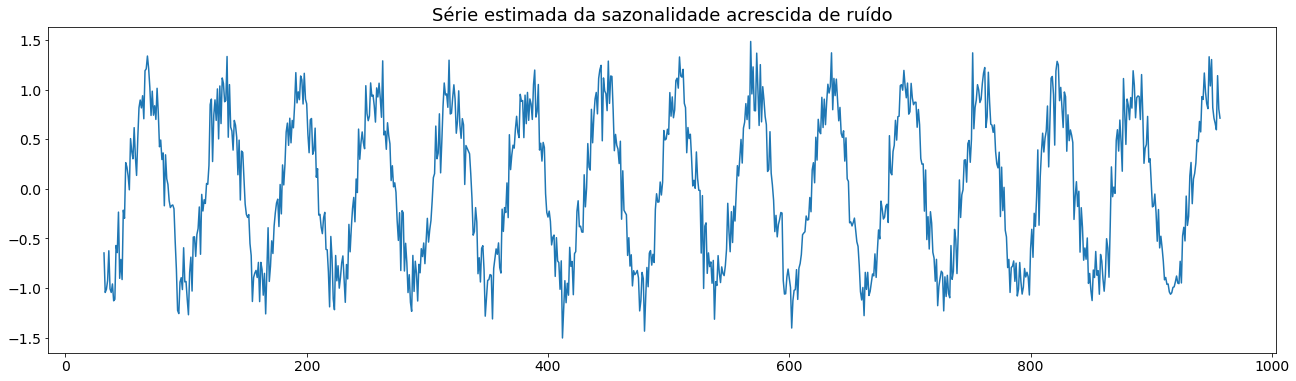

In [ ]:
_ = (X__["X"] - X__[f"mm{d}"]).plot(title="Série estimada da sazonalidade acrescida de ruído")

##### Aplicando na série de temperatura

In [ ]:
n = 52
sa_ = serie_aracaju.tavg.to_frame()
sa_.columns = ["X"]

for i in range(n):
  sa_[f"X_lag{i+1}"] = sa_["X"].shift(-(i+1))
  sa_[f"X_lead{i+1}"] = sa_["X"].shift(i+1)

sa_[f"mm{n}"] = sa_.sum(axis=1) / (2*n + 1)
sa_ = sa_.iloc[n:]
sa_ = sa_.iloc[:-n]

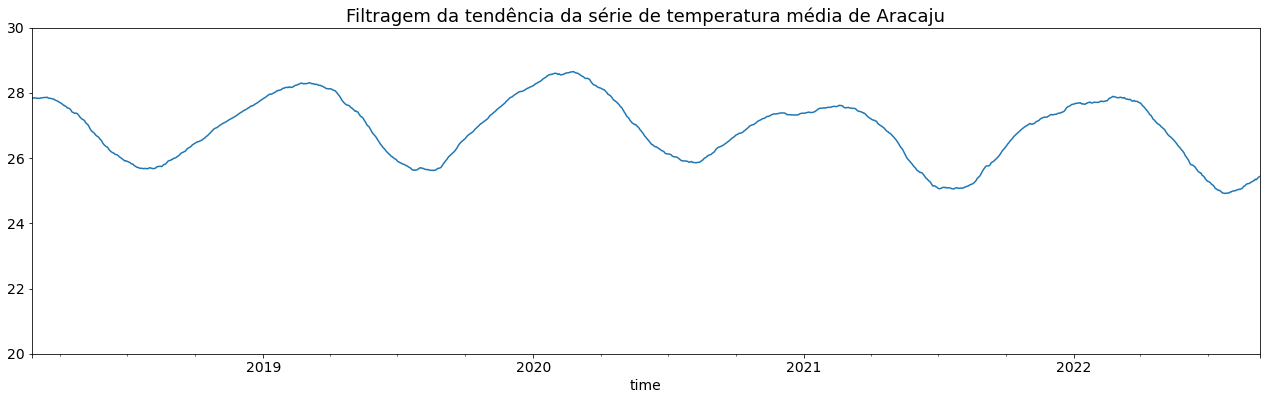

In [ ]:
_ = sa_[f"mm{n}"].plot(title="Filtragem da tendência da série de temperatura média de Aracaju", ylim=(20,30))

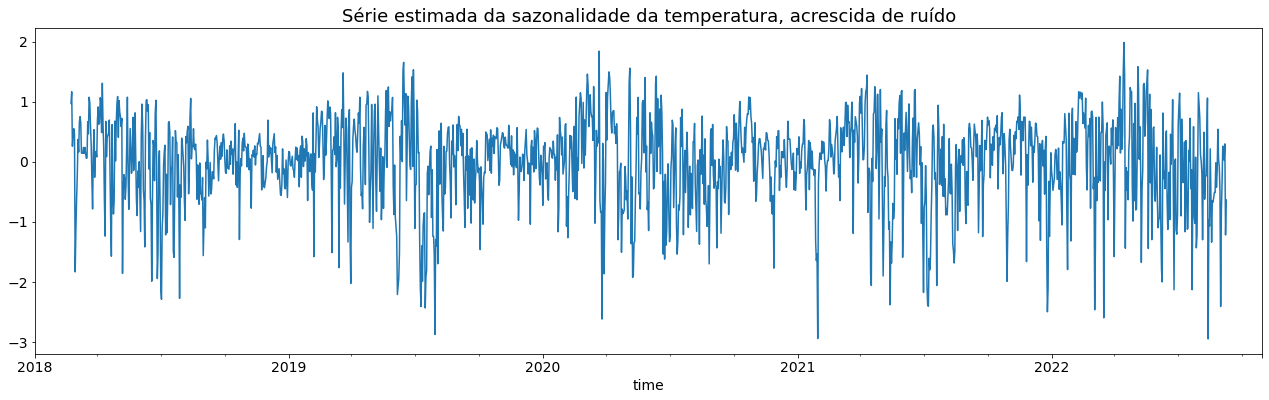

In [ ]:
(serie_aracaju.tavg - sa_[f"mm{n}"]).plot(title="Série estimada da sazonalidade da temperatura, acrescida de ruído")

Para dados mensais (d=12 meses; q=6 meses)

\begin{align}
T_t = \frac{1}{12}(\frac{1}{2} X_{t-6} + X_{t-5} + ... + X_{t+5} + \frac{1}{2} X_{t+6})
\end{align}

para t = 7, ... ,N - 6

In [ ]:
d2 = 365
q2 = d2 // 2
sa__ = serie_aracaju.tavg.to_frame()
sa__.columns = ["X"]

for i in range(q2):
  sa__[f"X_lag{i+1}"] = sa__["X"].shift(-(i+1-q2)) if i != (q2-1) else sa__["X"].shift(-(i+1-q2))/2
  sa__[f"X_lead{i+1}"] = sa__["X"].shift((i+1-q2)) if i != (q2-1) else sa__["X"].shift((i+1-q2))/2

sa__[f"mm{d2}"] = sa__.sum(axis=1) / d2
sa__ = sa__.iloc[q2:]
sa__ = sa__.iloc[:-q2]

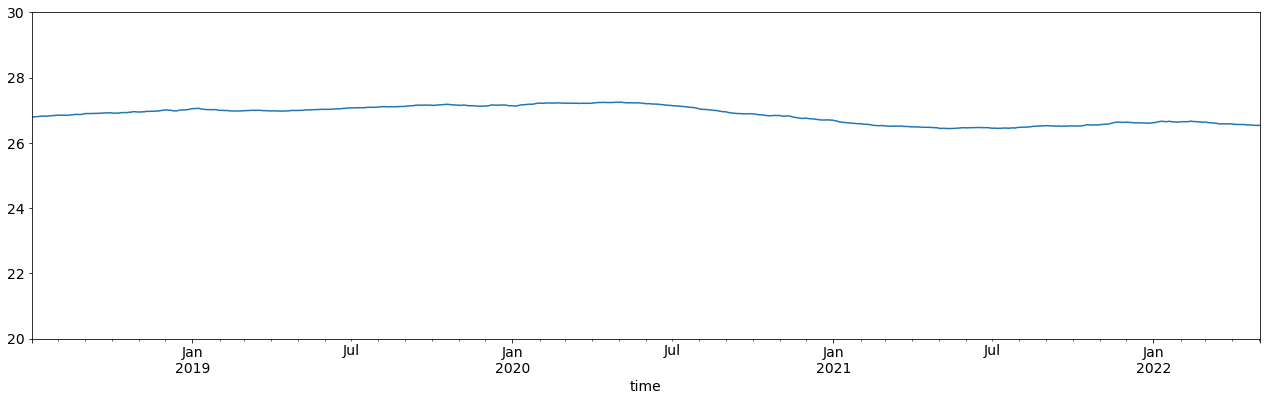

In [ ]:
_ = sa__[f"mm{d2}"].plot(ylim=(20,30))

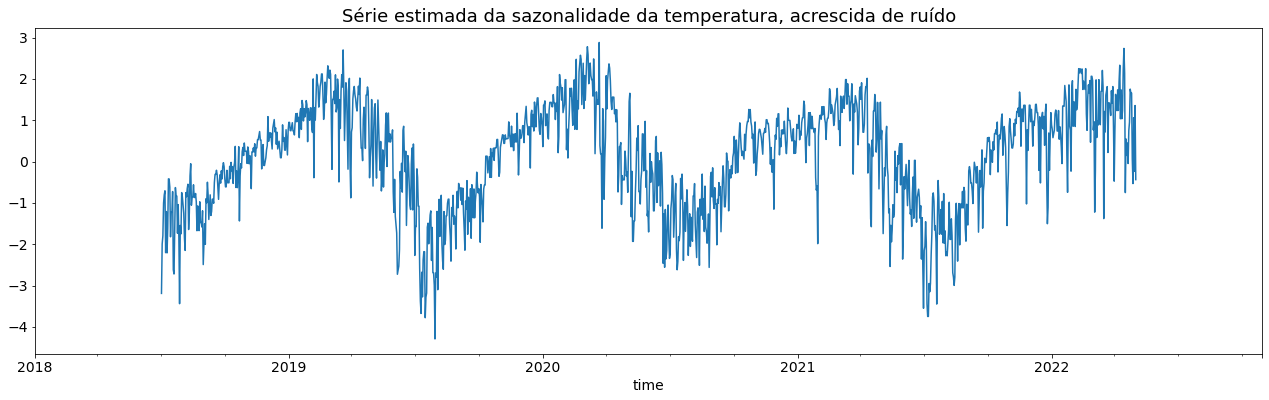

In [ ]:
_ = (serie_aracaju.tavg - sa__[f"mm{d2}"]).plot(title="Série estimada da sazonalidade da temperatura, acrescida de ruído")

Retornando à ferramenta do statsmodel...

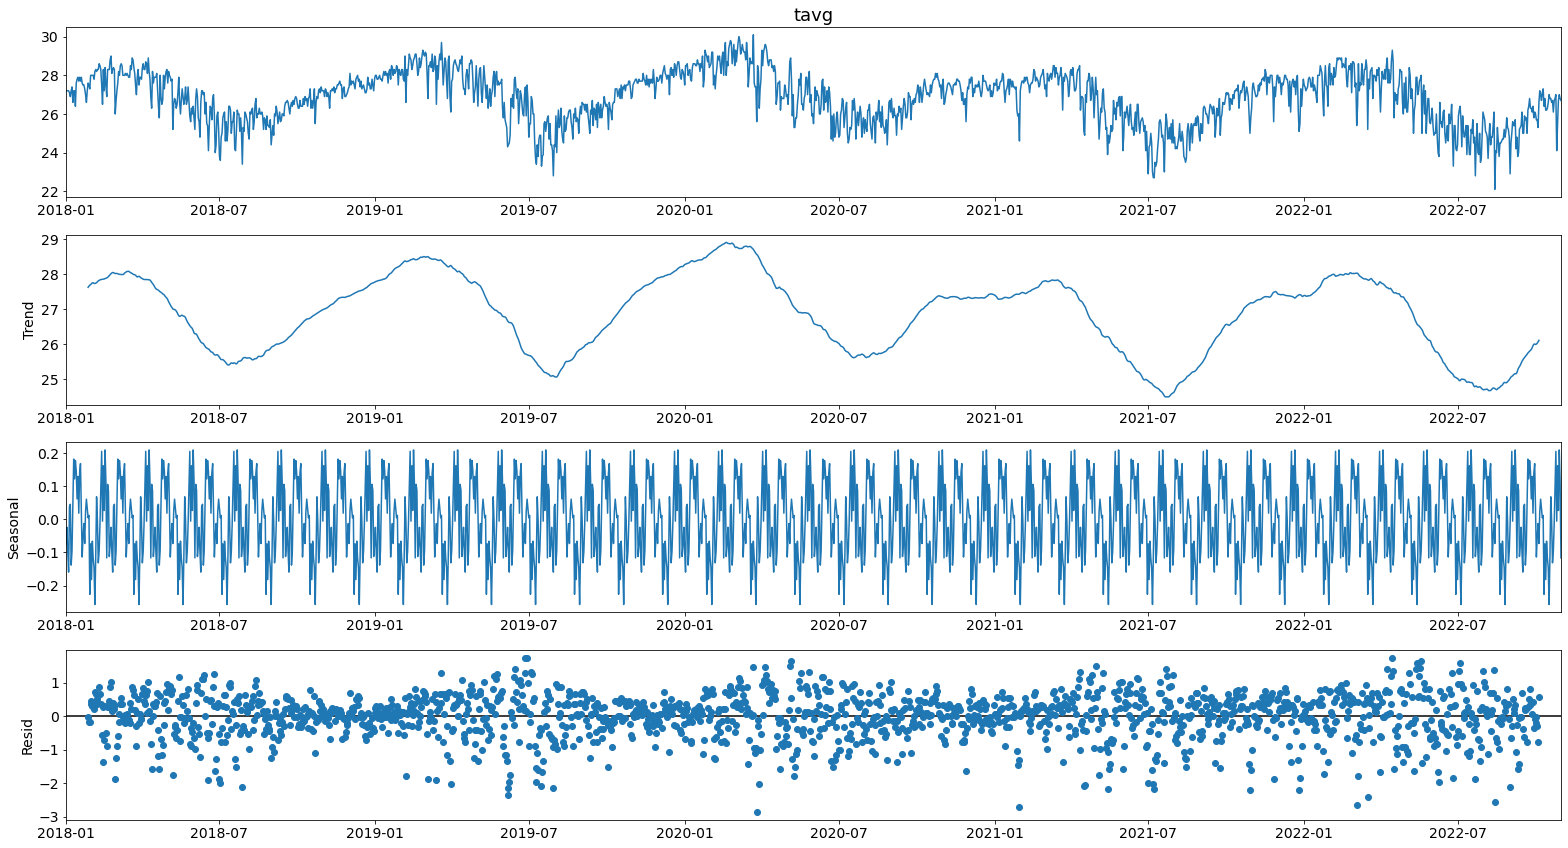

In [ ]:
plt.rcParams["figure.figsize"] = (22,12)
result = sm.tsa.seasonal_decompose(serie_aracaju.tavg, model='additive', period=freq_to_period("W"))
_ = result.plot()

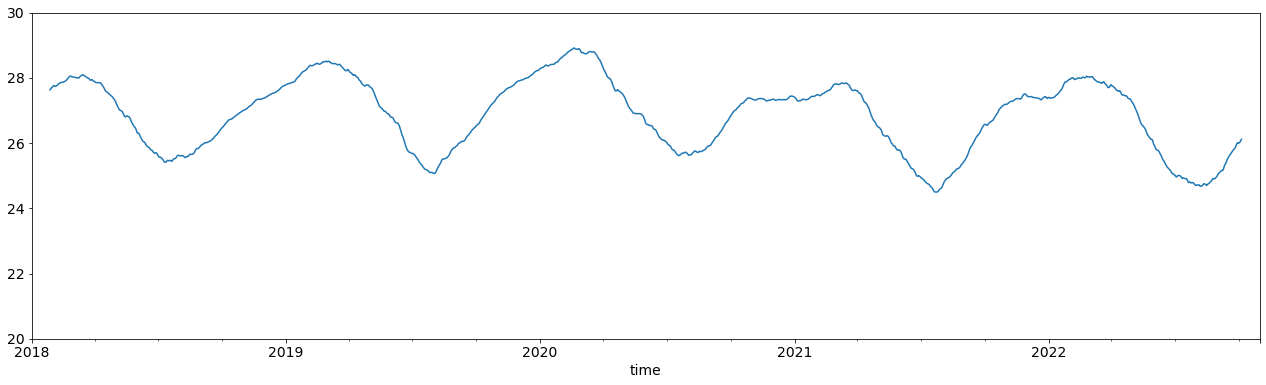

In [ ]:
plt.rcParams["figure.figsize"] = (22,6)
_ = result.trend.plot(ylim=(20,30))

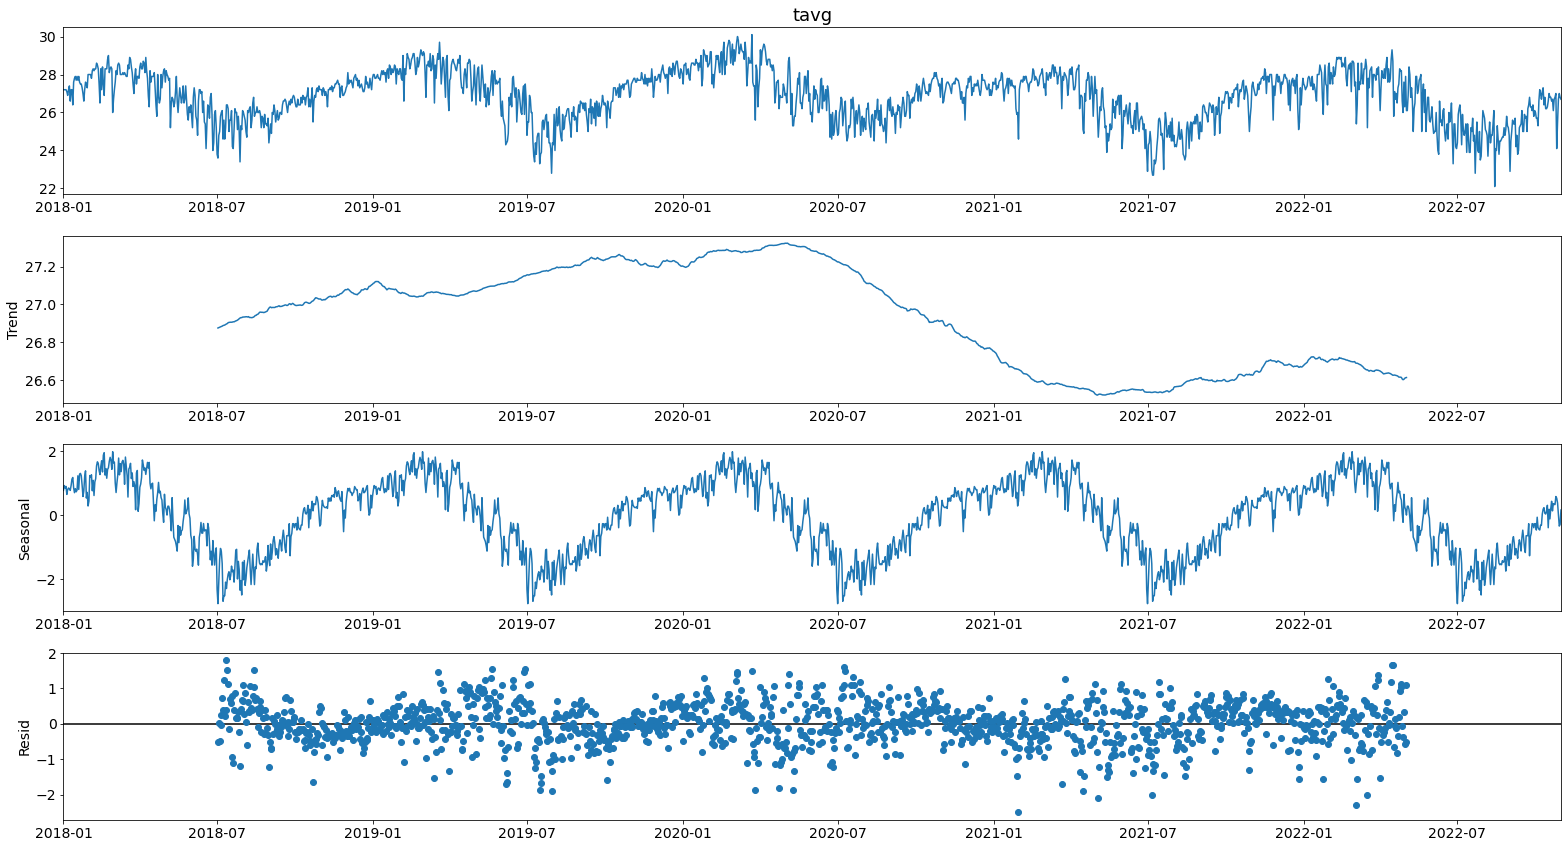

In [ ]:
plt.rcParams["figure.figsize"] = (22,12)
result = sm.tsa.seasonal_decompose(serie_aracaju.tavg, model='additive', period=365)
_ = result.plot()

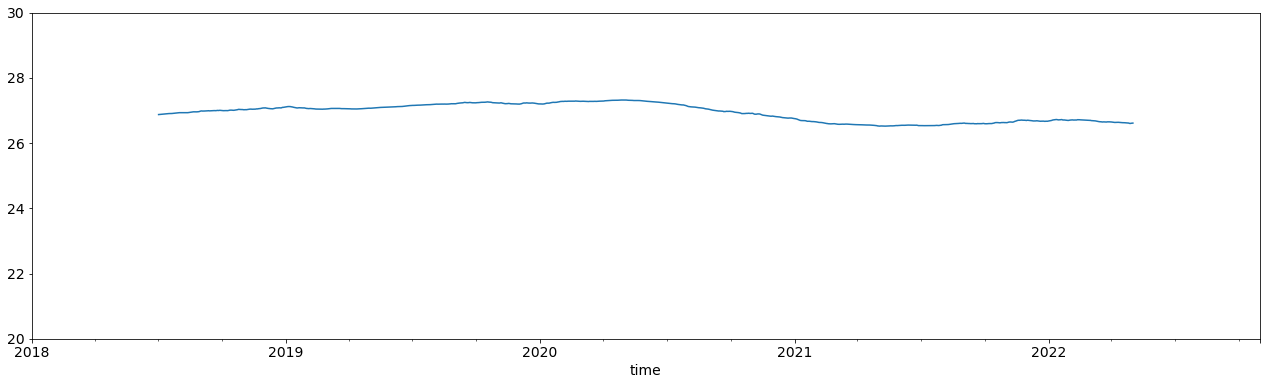

In [ ]:
plt.rcParams["figure.figsize"] = (22,6)
_ = result.trend.plot(ylim=(20,30))

#### Trabalhando com a série de câmbio de dólar real

In [ ]:
d3 = 365
q3 = d3 // 2
sa_d = serie_dolar.Close.to_frame()
sa_d.columns = ["X"]

for i in range(q3):
  sa_d[f"X_lag{i+1}"] = sa_d["X"].shift(-(i+1-q3)) if i != (q3-1) else sa_d["X"].shift(-(i+1-q3))/2
  sa_d[f"X_lead{i+1}"] = sa_d["X"].shift((i+1-q3)) if i != (q3-1) else sa_d["X"].shift((i+1-q3))/2

sa_d[f"mm{d3}"] = sa_d.sum(axis=1) / d3
sa_d = sa_d.iloc[q3:]
sa_d = sa_d.iloc[:-q3]

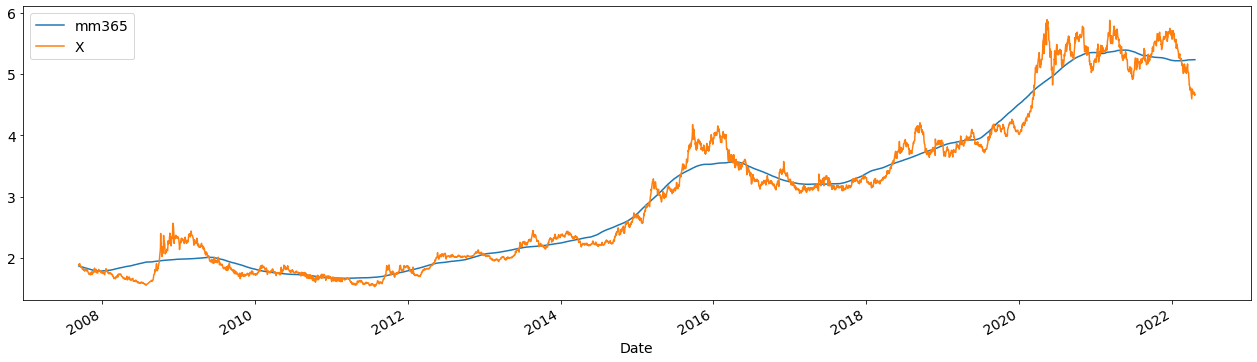

In [ ]:
_ = sa_d[[f"mm{d3}","X"]].plot()

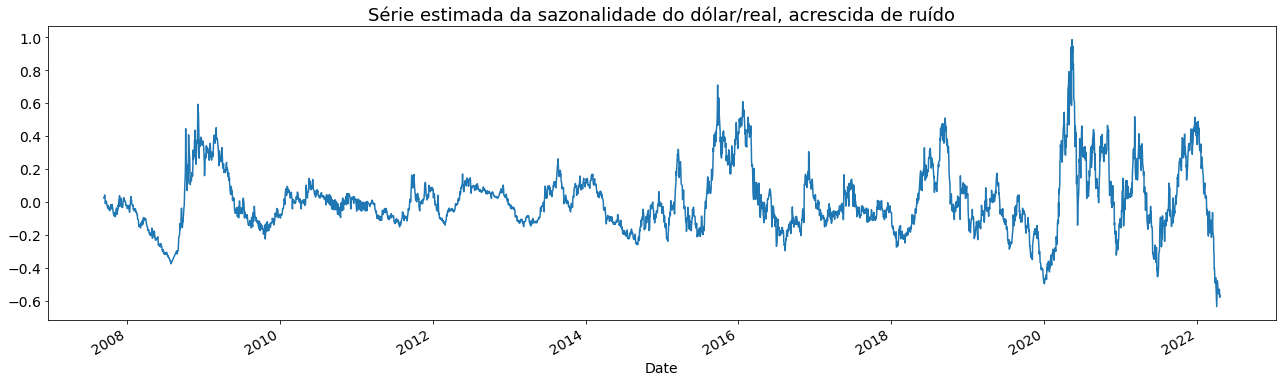

In [ ]:
_ = (sa_d.X - sa_d[f"mm{d3}"]).plot(title="Série estimada da sazonalidade do dólar/real, acrescida de ruído")

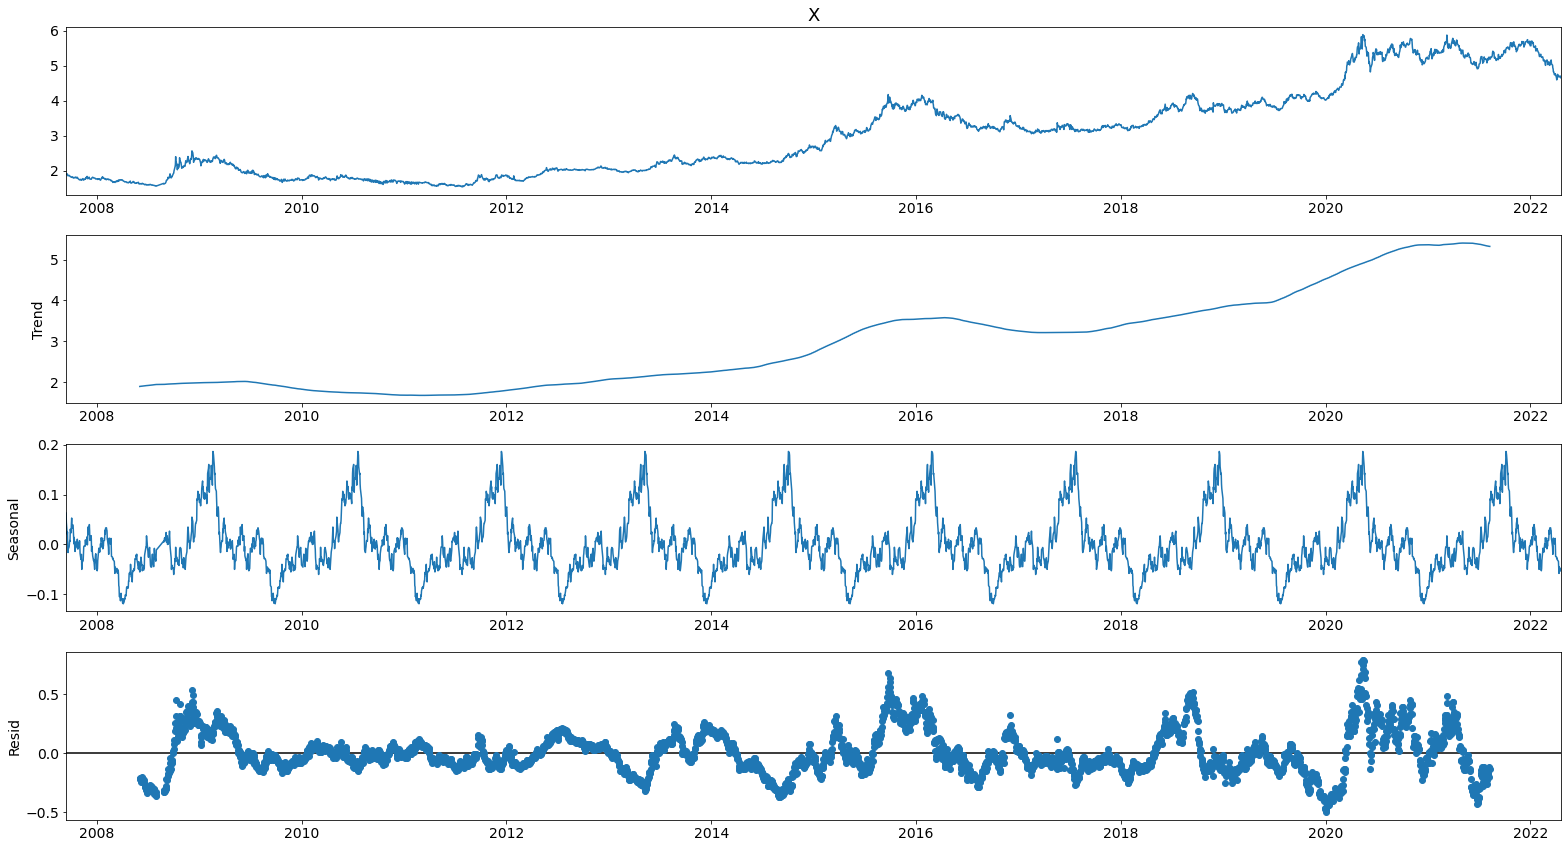

In [ ]:
plt.rcParams["figure.figsize"] = (22,12)
result_dolar = sm.tsa.seasonal_decompose(sa_d.X, model='additive', period=365)
_ = result_dolar.plot()

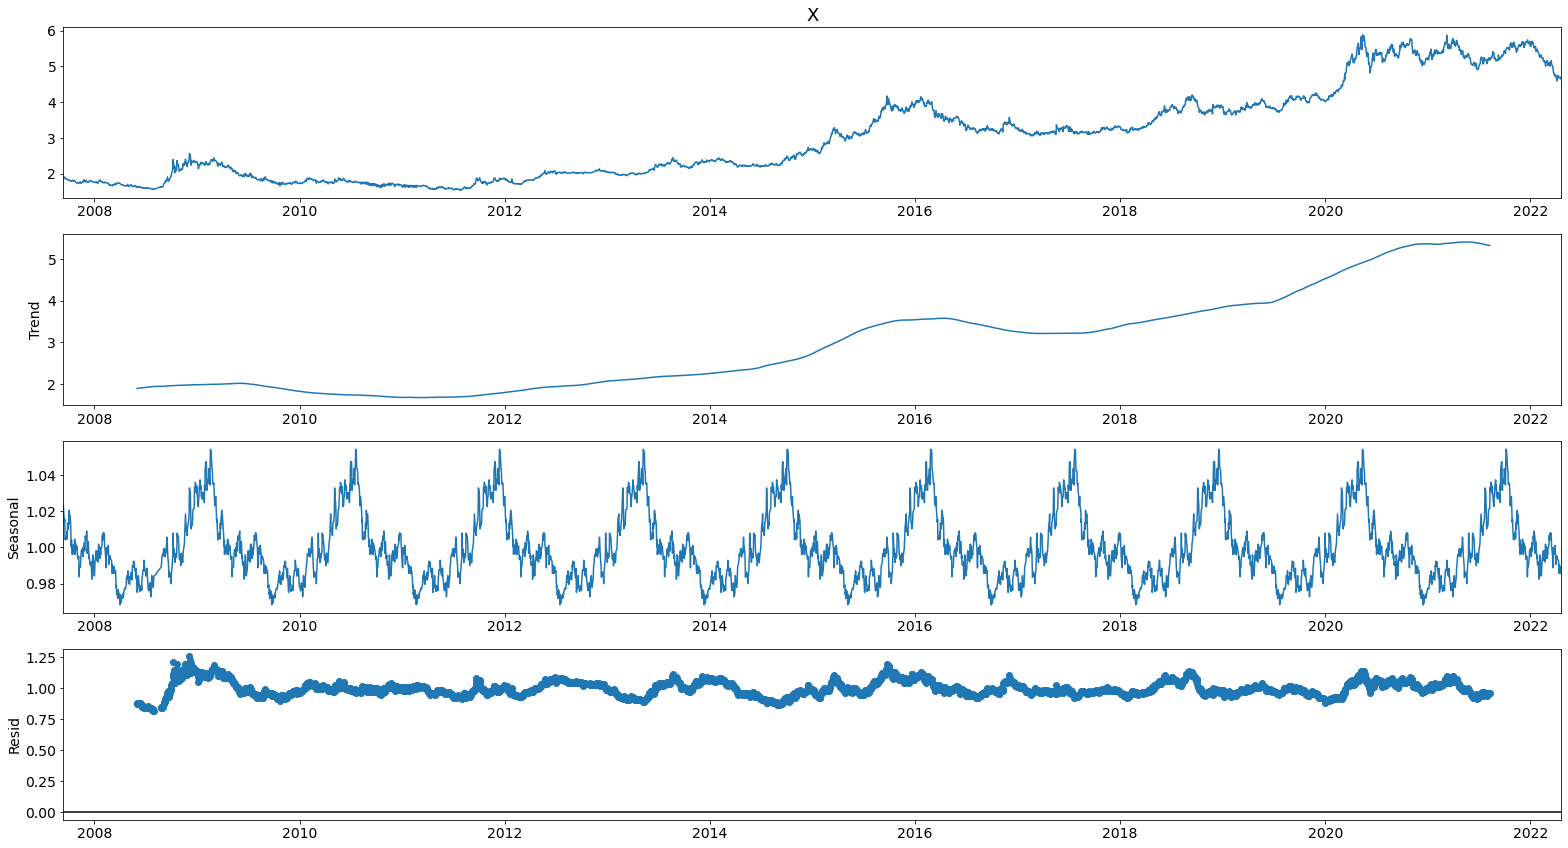

In [ ]:
result_dolar = sm.tsa.seasonal_decompose(sa_d.X, model='multiplicative', period=365)
_ = result_dolar.plot()

Outras aplicações de médias móveis

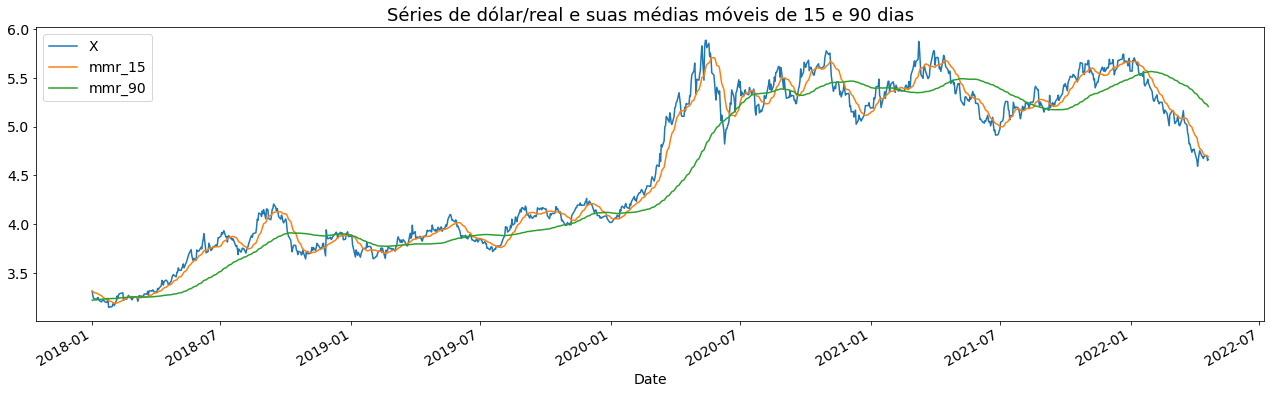

In [ ]:
plt.rcParams["figure.figsize"] = (22,6)
sa_d["mmr_15"] = sa_d.X.rolling(15).mean()
sa_d["mmr_90"] = sa_d.X.rolling(90).mean()
_ = sa_d[sa_d.index > "2018-01-01"][["X","mmr_15","mmr_90"]].plot(title="Séries de dólar/real e suas médias móveis de 15 e 90 dias")

A estratégia de convergência e divergência das médias móveis (MACD) é uma das estratégias mais simples para identificarmos alterações nas direções dos mercados.
[Saiba mais](https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd)

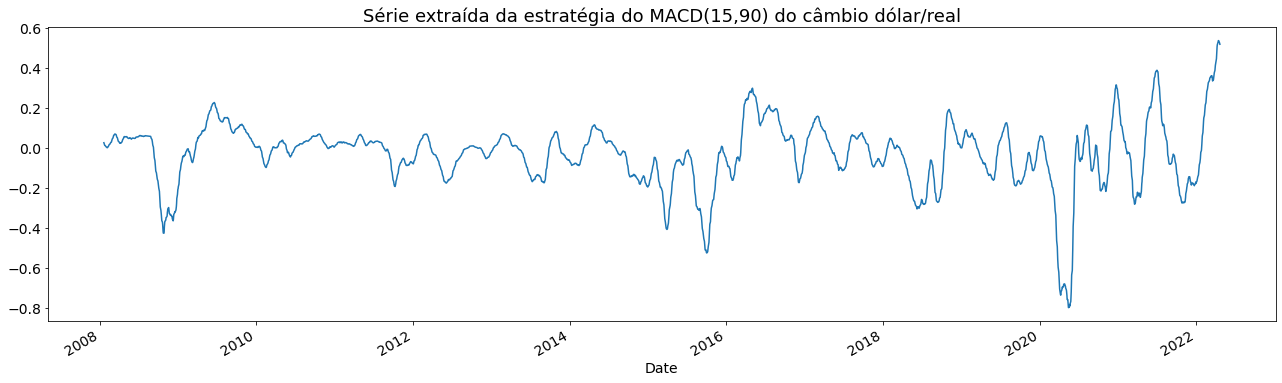

In [ ]:
_ = (sa_d["mmr_90"] - sa_d["mmr_15"]).plot(title="Série extraída da estratégia do MACD(15,90) do câmbio dólar/real")

Útil também para identificarmos:
- Ações de um fraudador
- Momentos de maior consumo de um produto
- Antecipações a sobrecargas e sobreuso de sistemas

## Exercício

1. Qual o tendência extraída de uma filtragem da série da temperatura média da cidade de Porto Alegre, quando analisamos a série de 2018 a 2022?
2. Qual o o efeito sazonal da temperatura média da cidade de Porto Alegre, quando analisamos a série de 2018 a 2022?
3. Qual o tendência extraída de uma filtragem da série da temperatura média intradiária (a cada hora do dia) da cidade de Porto Alegre, se analisarmos apenas os meses de janeiro a julho de 2020?